In [1]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
plt.style.use('ggplot')


In [2]:
### Creates initial dataframe from .txt files
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]

## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

# for filename in os.listdir('corpus_addendum/'): 
#     indiv = []
#     path = folder + filename
#     print(path)
#     if os.path.isfile(path) and filename.endswith(".txt"): 
#         with open(path, "r") as file:
#             p = filename.split('-')[1][:-4]
#             indiv.append(p)
#             indiv.append(pres_dict[p]['party'])
#             indiv.append(file.read())
#     data.append(indiv)

#converts the dictionary to a dataframe
df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)

def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False

speech_type = ['interview', 'debate', 'inaugural address', 'state of the union', 'press conference']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))

## Use this function to find parts of the debates that belong to each speaker
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

In [3]:
df.head()

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [4]:
df.head()

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [5]:
idx = [5 ,13, 23, 26, 28, 41,60, 252, 253, 260, 265, 449, 453]
opponent = [['clinton', 'democrat'], ['dukakis', 'democrat'], ['ford', 'republican'], ['ford', 'republican'],
            ['ford', 'republican'], ['reagan', 'republican'], ['dole', 'republican'], ['nixon', 'republican'], ['nixon', 'republican'],
            ['nixon', 'republican'], ['nixon', 'republican'], ['mondale','democrat'], ['mondale','democrat']]
        
delimiters = [['Bush.>', '>', '<Governor Clinton.', '>'], ['BUSH:>', '<', '<DUKAKIS:','>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'],['THE PRESIDENT.>', '<', '<GOVERNOR REAGAN.', '>'],
             ['<PRESIDENT CLINTON:>', '<', '<SENATOR DOLE:', '<'],['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'],
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], 
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<The President.>', '<', '<Mr. Mondale.', '>'],
              ['<PRESIDENT REAGAN:>', '<', '<MR. MONDALE:', '>']]
opponents = []
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False, False])
opponents = pd.DataFrame(data = opponents, columns = df.columns)
df = pd.concat([df, opponents])

In [6]:
import pprint
# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

url = 'https://www.debates.org/voter-education/debate-transcripts/'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

classes = []
class_num = [i for i in range(100, 141)]
for v in [138, 139, 133, 140, 135, 136, 137, 134, 130, 132, 129, 127, 121, 122, 118, 101]:
    class_num.remove(v)

for i in class_num:
    classes.append("page_item page-item-"+str(i))

debate_names = [['kaine', 'democrat', 'pence', 'republican'], ['obama', 'democrat', 'romney', 'republican'],
                ['obama', 'democrat', 'romney', 'republican'], ['biden', 'democrat', 'ryan', 'republican'],
               ['obama', 'democrat', 'romney', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['biden', 'democrat', 'palin', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['mccain', 'republican', 'obama', 'democrat'], ['bush', 'republican', 'kerry', 'democrat'],
               ['bush','republican','kerry','democrat'], ['cheney', 'republican', 'edwards', 'democrat'],
               ['bush', 'republican', 'kerry', 'democrat'], ['gore', 'democrat', 'bush', 'republican'],
                ['lieberman', 'democrat', 'cheney', 'republican'], ['gore', 'democrat', 'bush', 'republican'],
                ['gore', 'democrat', 'bush', 'republican'], ['gore', 'democrat', 'kemp', 'republican'],
                ['clinton', 'democrat', 'dole', 'republican'], ['gore', 'democrat', 'quayle', 'republican'],
                ['clinton', 'democrat', 'bush', 'republican'], ['clinton', 'democrat', 'bush', 'republican'],
                ['bush', 'republican', 'dukakis', 'democrat'], ['bentsen', 'democrat', 'quayle', 'republican'],
                ['bush', 'republican','ferraro', 'democrat']]

### Gets text from each speech
links = []
for i in classes:
    x = soup.find_all(class_= i)
    links.append('http://debates.org/'+ str(x).split('"')[3])


results = []
for i, link in enumerate(links):
    req = requests.get(link)
    soup_link = BeautifulSoup(req.content, 'html.parser')
    text = soup_link.get_text()
    text = text.lower()
    for v in [0, 2]:
        text_1 = find_between(text, '\n'+debate_names[i][v]+":", ':')
        results.append([debate_names[i][v], debate_names[i][v+1]] + [0, 0, 0, 0] + [text_1] + [False, True, False, False, False])
for i in [18, 20, 24, 27, 31, 33]:
     results[i][0]=results[i][0].replace("bush", "gwbush")
more_debates = pd.DataFrame(data = results, columns = df.columns)
df = pd.concat([df, more_debates])


In [260]:
df = df.reset_index()

In [267]:
df.index

RangeIndex(start=0, stop=549, step=1)

## EDA!

Counts of types and presidents

In [233]:
df.count()

name                  549
party                 549
war                   549
speech                549
title                 549
date                  549
text                  549
interview             549
debate                549
inaugural address     549
state of the union    549
press conference      549
text length           549
accurate              549
dtype: int64

In [234]:
print('Speeches by president')
print(df.name.value_counts())
print('')
print('speeches by party')
print(df.party.value_counts())

Speeches by president
lbjohnson      71
reagan         60
obama          54
fdroosevelt    49
kennedy        45
gwbush         45
clinton        43
hoover         29
bush           27
nixon          27
carter         22
truman         19
ford           17
eisenhower      6
gore            5
kerry           3
romney          3
mccain          3
biden           2
quayle          2
cheney          2
dole            2
dukakis         2
mondale         2
ryan            1
kemp            1
bentsen         1
palin           1
pence           1
kaine           1
ferraro         1
lieberman       1
edwards         1
Name: name, dtype: int64

speeches by party
democrat      322
republican    227
Name: party, dtype: int64


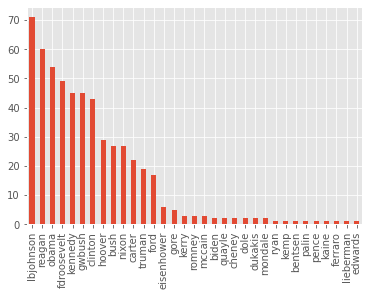

In [235]:
df['name'].value_counts().plot(kind='bar')

LBJ had the most speeches, which lead me to wonder if these were disproportionately press conferences due to the Vietnam War.  It turns out that yes, he had the most press conferences in the corpus, 23 in total.

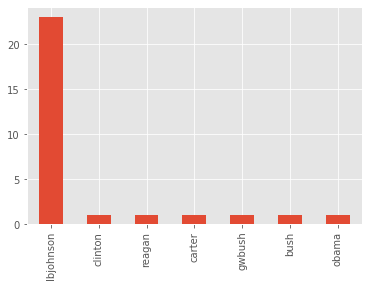

In [236]:
df[df['press conference']== True]['name'].value_counts().plot(kind='bar')

In [237]:
df.groupby('name').sum()

,interview,debate,inaugural address,state of the union,press conference,text length
name,,,,,,
bentsen,0.0,1.0,0.0,0.0,0.0,5683
biden,0.0,2.0,0.0,0.0,0.0,12187
bush,0.0,6.0,1.0,3.0,1.0,93880
carter,0.0,4.0,1.0,3.0,1.0,68413
cheney,0.0,2.0,0.0,0.0,0.0,12733
clinton,0.0,5.0,0.0,7.0,1.0,157844
dole,0.0,2.0,0.0,0.0,0.0,14511
dukakis,0.0,2.0,0.0,0.0,0.0,5361
edwards,0.0,1.0,0.0,0.0,0.0,5768


In [238]:
df['text length'] = df.text.apply(lambda x: len(x.split(' ')))

Assuming 150 words spoken per minute, speeches were on average 23 minutes long

In [239]:
df['text length'].mean()/150

23.18415300546448

In [240]:
df.sort_values(by='text length', ascending=False)

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
325,lbjohnson,democrat,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 10, 1967","\nMr. Speaker, Mr. Vice President, distinguish...",False,False,False,True,False,14176,True
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229,True
10,mccain,republican,0,0,0,0,"well, thank you, jim. and thanks to everybody...",False,True,False,False,False,12353,False
8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902,False
214,hoover,republican,nw,"<title=""First State of the Union Address"">\n<d...",First State of the Union Address,"December 3, 1929",\nTo the Senate and House of Representatives:\...,False,False,False,True,False,10830,na
274,lbjohnson,democrat,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 17, 1968","\nMr. Speaker, Mr. President, Members of the C...",False,False,False,True,False,9608,na
72,clinton,democrat,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 24, 1995","\nMr. President, Mr. Speaker, members of the 1...",False,False,False,True,False,9193,na
48,clinton,democrat,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 27, 2000","\nMr. Speaker, Mr. Vice President, members of ...",False,False,False,True,False,8996,True
273,lbjohnson,democrat,war,"<title=""A Conversation with President Lyndon J...",A Conversation with President Lyndon Johnson,"December 19, 1967","\n\n<Mr. RATHER. Mr. President, I think any Am...",False,False,False,False,False,8882,na
284,lbjohnson,democrat,war,"<title=""Speech to the Associated Press Luncheo...",Speech to the Associated Press Luncheon,"April 20, 1964",\nPaul Miller and my fellow Americans: Last Fr...,False,False,False,False,False,8686,na


In [241]:
vocab = set()
total = []
df['text'].str.lower().str.split().apply(vocab.update)
df['text'].str.lower().str.split().apply(total.append)
total = [item for sublist in total for item in sublist]
print(f'The vocabulary of the corpus is {len(vocab)} unique words & {len(total)} total words.')

The vocabulary of the corpus is 57629 unique words & 1928737 total words.


In [242]:
new = df.copy()

In [268]:
for i in vocab:
    instance = 0
    for j in range(549):
        if ' '+i+' ' in new.loc[j, 'text']:
            instance += 1

KeyError: 486

In [94]:
print('According to the count vectorizer the number of words is 25518')

According to the count vectorizer the number of words is 25518


In [244]:
count_vector = CountVectorizer(stop_words='english', max_features=None)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
BoW = pd.DataFrame(X.toarray(), columns=labels)


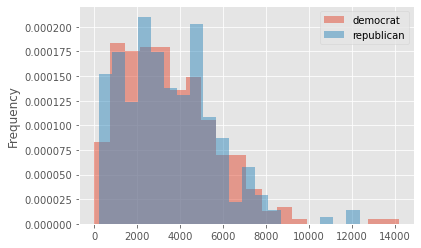

In [245]:
fig, ax = plt.subplots()
df[df['party'] == 'democrat']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'democrat')
df[df['party'] == 'republican']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'republican')
ax.legend()

In [247]:
df[df['name'] == 'obama']

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
360,obama,democrat,war,"<title=""Commencement Address at Rutgers Univer...",Commencement Address at Rutgers University,"May 15, 2016",\nHello Rutgers! <Applause.> R-U rah-rah! <App...,False,False,False,False,False,4912,na
361,obama,democrat,war,"<title=""2016 State of the Union Address"">\n<da...",2016 State of the Union Address,"January 12, 2016","\nMr. Speaker, Mr. Vice President, Members of ...",False,False,False,True,False,6024,na
362,obama,democrat,war,"<title=""Acceptance Speech at the Democratic Na...",Acceptance Speech at the Democratic National C...,"August 28, 2008",\nTo Chairman Dean and my great friend Dick Du...,False,False,False,False,False,4610,na
363,obama,democrat,war,"<title=""Address on the End of the Combat Missi...",Address on the End of the Combat Mission in Iraq,"August 31, 2010","\nGood evening. Tonight, I'd like to talk to y...",False,False,False,False,False,2549,na
364,obama,democrat,war,"<title=""Speech on the BP Oil Spill"">\n<date=""J...",Speech on the BP Oil Spill,"June 15, 2010","\nGood evening. As we speak, our nation faces ...",False,False,False,False,False,2677,True
365,obama,democrat,war,"<title=""Remarks on the Lilly Ledbetter Fair Pa...",Remarks on the Lilly Ledbetter Fair Pay Restor...,"January 29, 2009","<title=""Remarks on the Lilly Ledbetter Fair Pa...",False,False,False,False,False,900,True
366,obama,democrat,war,"<title=""Speech on Health Care Reform"">\n<date=...",Speech on Health Care Reform,"March 15, 2010","\n<THE PRESIDENT:> Hello, Ohio! <Applause.> It...",False,False,False,False,False,4158,True
367,obama,democrat,war,"<title=""Inaugural Address"">\n<date=""January 20...",Inaugural Address,"January 20, 2009",\nI stand here today humbled by the task befor...,False,False,True,False,False,2376,na
368,obama,democrat,war,"<title=""2012 State of the Union Address"">\n<da...",2012 State of the Union Address,"January 24, 2012","\nMr. Speaker, Mr. Vice President, members of ...",False,False,False,True,False,7038,na
369,obama,democrat,war,"<title=""Nominee Acceptance Speech at 2012 Demo...",Nominee Acceptance Speech at 2012 Democratic N...,"September 6, 2012","<title=""Nominee Acceptance Speech at 2012 Demo...",False,False,False,False,False,4592,True


In [248]:
#3/7 of presidents are classified as "not war" (Hoover, Eisenhower, Ford, Carter, Reagan, Clinton).  
#These presidents have a disproportionate number of 1 term presidents, so their share of speeches are roughly
#proportional to their time in office
print(df['war'].value_counts())
print(169/486, 3/7)

war    317
nw     169
0       63
Name: war, dtype: int64
0.3477366255144033 0.42857142857142855


In [249]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words=sw, max_features=100)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
BoW = pd.DataFrame(X.toarray(), columns=labels)
BoW

,000,action,administration,ago,america,american,americans,back,believe,best,...,united,us,use,war,well,without,work,working,world,years
0,0,1,2,5,3,9,0,0,0,5,...,14,3,10,9,10,2,3,1,16,5
1,3,4,0,0,6,6,0,1,0,0,...,9,2,0,0,0,1,1,0,4,0
2,1,2,1,3,6,3,1,0,1,0,...,10,1,0,2,3,3,2,1,9,1
3,1,3,0,0,14,5,8,1,0,0,...,18,6,3,0,6,3,3,2,27,0
4,0,1,0,4,26,25,2,6,1,2,...,13,11,2,20,1,4,2,1,31,7
5,3,0,2,1,6,19,2,6,15,4,...,8,5,5,10,21,2,7,9,12,6
6,3,3,0,2,14,18,5,6,4,2,...,2,16,5,6,5,7,8,2,23,4
7,1,0,1,3,19,7,5,3,4,0,...,3,10,0,6,4,1,5,0,11,14
8,0,0,0,2,8,4,0,6,16,2,...,32,22,14,4,22,12,22,2,24,2
9,2,1,0,8,38,19,10,9,7,5,...,8,3,1,6,9,2,5,1,18,16


## Looking at words by president!

In [61]:
words_by_pres = df.groupby(['name'])['text'].apply(lambda x: ','.join(x)).reset_index()


In [63]:
words_by_pres['length'] = words_by_pres['text'].apply(lambda x: len(x.split(' ')))

In [64]:
words_by_pres

,name,text,length
0,bentsen,this debate tonight is not about the qualific...,5683
1,biden,"what is was, it was a tragedy, martha. it — c...",12186
2,bush,\nThank you all very much. Good luck. Please b...,93854
3,carter,"Well, I think this Republican administration ...",68392
4,cheney,"gwen, i want to thank you, and i want to than...",12732
5,clinton,"\nMr. Speaker, Mr. Vice President, members of ...",157802
6,dole,I think the basic difference is -- and I have...,14510
7,dukakis,"Passionless? Peter, I care deeply about peop...",5360
8,edwards,"thank you.\nthank you, gwen, for moderating t...",5768
9,eisenhower,\nIn this spring of 1953 the free world weighs...,17684


In [251]:
def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = words_by_pres['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)


NameError: name 'words_by_pres' is not defined

In [252]:
def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = words_by_pres['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
tf = TfidfVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    use_idf = False,
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = tf.fit_transform(custom_tokens.keys())
labels = tf.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), index = words_by_pres['name'], columns=labels)
BoW

NameError: name 'words_by_pres' is not defined

Of the top 16, politicians with the highest term frequency of "woman" 5 were Republicans and 11 were Democrats.

Of the bottom 16, it was 10 Repbulicans and 6 Democrats

In [253]:
BoW.sort_values('woman', ascending = False)

KeyError: 'woman'

In [254]:
pd.options.display.max_columns = 200

In [255]:
BoW.sort_values('tax', ascending = False)

,000,action,administration,ago,america,american,americans,back,believe,best,better,bill,billion,business,cannot,care,change,children,congress,continue,country,done,economic,economy,end,federal,forces,free,freedom,future,give,good,got,government,great,health,help,history,home,hope,important,jobs,keep,know,law,life,long,look,military,million,much,nation,national,nations,need,never,new,next,nuclear,peace,people,percent,plan,policy,power,president,program,progress,public,put,right,rights,said,security,see,soviet,state,states,still,support,sure,system,take,tax,thank,things,think,together,tonight,union,united,us,use,war,well,without,work,working,world,years
247,11,3,6,1,2,13,1,0,1,0,0,1,4,20,6,0,4,0,9,2,4,1,16,11,1,7,1,5,1,4,5,0,0,6,3,0,2,1,5,0,6,4,3,2,7,3,4,0,0,8,5,1,1,0,10,1,28,4,0,0,8,8,1,4,1,0,8,0,11,0,0,1,0,2,0,0,0,13,1,1,0,30,5,165,0,0,0,2,0,0,13,7,12,2,15,6,1,0,9,8
447,4,1,0,2,10,3,3,7,2,2,4,23,3,6,1,0,3,1,4,2,2,4,12,6,1,5,0,2,1,6,4,1,0,15,4,0,4,2,2,3,2,3,3,3,0,4,0,0,0,0,7,4,0,0,4,7,4,3,0,0,11,13,5,1,1,1,12,0,0,5,2,0,5,7,9,0,1,1,2,3,1,3,4,54,1,2,0,3,1,0,0,8,0,0,8,1,3,2,3,20
534,1,3,19,6,36,22,4,1,7,4,4,12,5,5,10,0,5,6,4,1,30,4,2,35,0,8,0,3,0,0,5,2,9,12,3,0,1,4,5,0,7,12,1,3,3,11,3,3,0,4,3,7,3,1,28,1,13,9,0,0,38,15,5,13,0,19,2,2,8,5,3,2,16,6,2,0,2,11,2,0,4,9,8,49,3,1,16,2,1,0,11,13,4,3,19,8,18,8,16,25
414,1,0,2,3,1,1,6,3,3,1,2,11,18,3,0,0,0,1,7,1,0,2,8,4,3,3,1,0,0,0,1,0,1,17,2,0,4,6,2,2,1,4,0,6,0,0,3,3,0,2,1,1,3,0,3,0,6,4,0,0,7,15,2,3,1,2,9,0,0,2,4,0,6,0,3,0,2,2,4,5,1,4,1,45,1,1,2,1,1,0,0,8,2,0,9,2,4,1,0,12
490,13,2,3,3,4,5,1,2,7,2,6,9,26,4,2,0,0,4,39,0,14,7,1,12,2,26,0,0,1,3,15,11,2,16,4,1,4,7,0,1,2,24,2,3,1,3,0,3,2,13,3,3,4,0,2,3,5,6,1,0,19,13,1,2,2,22,12,0,1,0,3,1,4,3,2,0,2,12,4,0,2,3,5,37,0,1,22,2,2,1,12,7,0,2,7,0,5,7,0,21
508,7,0,0,1,17,5,4,10,8,5,5,0,15,11,0,15,2,2,2,2,7,9,4,11,0,10,0,4,1,2,4,8,3,15,6,13,4,0,1,1,4,17,7,12,0,3,2,10,6,10,3,5,2,0,11,1,6,2,0,0,53,14,23,0,0,31,5,0,0,13,17,3,26,3,5,0,17,3,2,2,8,1,14,29,4,6,10,3,0,0,0,6,0,0,20,1,12,4,5,10
533,12,5,3,8,21,8,2,3,8,1,3,18,5,6,1,1,1,5,7,0,11,1,2,5,5,0,0,2,0,11,7,8,7,4,2,3,1,3,5,3,8,22,0,6,5,0,0,2,1,23,9,3,2,0,1,5,29,5,0,3,17,7,43,4,0,27,0,6,0,7,12,2,29,0,2,0,0,14,2,3,0,2,8,28,4,0,14,2,7,0,14,4,3,1,8,1,7,8,7,29
505,13,3,0,0,7,12,4,6,5,3,1,2,8,0,1,8,2,2,2,6,10,6,1,4,4,1,7,2,0,0,5,4,6,4,5,3,8,1,1,2,1,5,7,19,1,5,3,22,8,14,3,1,1,2,16,7,2,3,5,2,46,16,1,5,0,18,3,0,1,9,10,0,34,13,2,0,1,5,1,3,10,1,16,27,2,5,7,3,1,0,7,14,3,12,13,1,4,5,12,5
446,1,0,1,0,7,7,2,0,1,3,1,7,0,1,1,0,0,3,2,0,3,1,8,4,1,0,0,0,4,1,0,1,0,5,0,0,0,6,1,5,1,2,1,2,1,4,4,0,0,1,1,4,0,1,0,3,5,1,0,0,5,2,1,0,0,0,1,1,0,1,0,2,1,1,1,0,0,2,0,0,0,0,1,27,3,0,1,0,0,0,2,6,0,0,1,1,5,1,3,3
184,2,0,1,3,2,5,3,1,0,0,0,1,0,1,0,0,0,0,4,0,2,0,1,0,0,2,0,0,1,0,0,2,0,2,2,0,0,0,1,0,1,0,0,0,0,1,1,2,0,0,2,1,0,0,0,0,4,0,0,0,5,2,2,1,0,4,0,1,0,0,0,0,1,0,0,0,0,3,0,0,0,0,1,26,5,0,0,1,0,1,3,2,0,1,2,0,1,2,1,1


In [83]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words='english', max_features=50)
X = count_vector.fit_transform(df.text)
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
labels = X.get_feature_names()
y_train = y_train.to_numpy()

## Initial Multinomial Bayes' run
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(f'Accuracy: {clf.score(X_test, y_test)}')
print(f'labels: {labels}')

ValueError: Shape of passed values is (499, 50), indices imply (499, 200)

In [256]:
### adding features up to 200
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
# %

## takes vectorized tokens, target values, and labels for the 
def MNB(vector_array, y, labels):
    BoW = pd.DataFrame(vector_array.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return (clf.predict(X_test), f'Accuracy: {clf.score(X_test, y_test)}')

print(MNB(X, df.party, labels))


(array(['republican', 'democrat', 'democrat', 'republican', 'democrat',
       'democrat', 'republican', 'republican', 'democrat', 'democrat',
       'democrat', 'democrat', 'democrat', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'republican', 'democrat', 'republican', 'republican',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'democrat', 'republican', 'democrat', 'republican', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'republican', 'republican', 'republican', 'democrat', 'republican',
       'democrat', 'democrat', 'republican', 'republican', 'republican',
       'democrat', 'democrat', 'democrat', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'republican', 'republican', 'republican',
       'r

In [257]:
### adding features up to 200
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200, ngram_range = ((1,4)))
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'republican' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'republican' 'republican'
 'democrat' 'dem

In [52]:
clf.classes_

array(['democrat', 'republican'], dtype='<U10')

In [258]:
def get_top_features(feature_logs, labels, num_features):
    ## returns the top featurs for dems, republications, as well as the features that are unique to 
    #each party in the top num_features
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique
    
    

## the most important features for each class after the 200 word, 3 n-gram
get_top_features(clf.feature_log_prob_, labels, 50)


(array(['hope', 'come', 'long', 'tax', 'like', 'future', 'good', 'don',
        'security', 'men', 'way', 'say', 'need', 'help', 'said', 'right',
        'believe', 'mr', 'today', 'great', 'nations', 'americans',
        'applause', 'let', 'congress', 'united states', 'want', 'work',
        'year', 'government', 'going', 'nation', 've', 'just', 'war',
        'states', 'peace', 'know', 'united', 'country', 'time', 'make',
        'america', 'think', 'years', 'new', 'american', 'president',
        'world', 'people'], dtype='<U15'),
 array(['future', 'life', 'mr', 'good', 'right', 'like', 'believe',
        'economic', 'help', '000', 'americans', 'need', 'federal',
        'security', 'don', 'nations', 'freedom', 'today', 'way', 'tax',
        'said', 'say', 'work', 'nation', 'year', 'want', 'great', 'let',
        'congress', 'country', 'war', 'just', 'going', 'make', 'think',
        'peace', 'know', 'united states', 'time', 'new', 'years', 've',
        'united', 'states', 'american

In [ ]:
print(f'Top words for democrats{np.array(labels)[last_5[:15]]}')
print(f'Top unique words for republicans{np.array(labels)[last_class_1[:15]]}')

In [ ]:
print(labels)

In [ ]:
### adding features up to 200, 3-grams, lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%

count_vector = CountVectorizer(max_features=200, ngram_range = ((1,4)), tokenizer=WordNetLemmatizer())
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

In [54]:
sw = stopwords.words('english')

In [335]:
## lemmatized

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
sw = stopwords.words('english')
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)
print(type(token_array))
print(token_array)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])
print(custom_tokens.keys())
X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

<class 'pandas.core.series.Series'>
0      [thank, much, good, luck, please, seated, than...
1      [want, talk, today, tragedy, somalia, mission,...
2      [life, nation, 're, called, upon, define, beli...
3      [mr, president, mr, speaker, member, united, s...
4      [thank, welcome, back, thank, much, good, afte...
5      [well, think, one, thing, distinguishes, exper...
6      [mr, speaker, mr, president, distinguished, me...
7      [many, friend, thank, tonight, thank, voter, s...
8      [president, gorbachev, good, evening, lady, ge...
9      [thank, much, thank, thank, much, proud, recei...
10     [fellow, citizen, last, night, ordered, u, mil...
11     [title=, '', address, joint, session, congress...
12     [mr, chief, justice, mr, president, vice, pres...
13     [think, 've, seen, deterioration, value, think...
14     [kuwait, liberated, iraq, 's, army, defeated, ...
15     [mr, president, thank, much, mr, secretary-gen...
16     [thank, governor, thank, much, welcome, good,

['republican' 'democrat' 'republican' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'republican' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'republican'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'republican' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'democrat' 'r

In [43]:
zero, one, zero_uniqe, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero}')
print(f'one unique: {one}')

zero: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'war' 'every'
 'united' 'america' 'make' 'think' 'government' 'mr' 'new' "n't" 'must'
 'time' 'one' 'country' 'state' 'world' 'nation' 'u' 'would' 'president'
 'year' 'american' 'people' "'s" '--']
one: ['soviet' 'need' 'way' 'today' 'want' 'freedom' 'first' 'say' 'let'
 'force' 'well' 'think' 'right' 'every' 'work' 'tax' 'many' '``'
 'congress' 'great' 'life' "'re" 'make' 'united state' 'war' "''" 'know'
 'mr' "'ve" 'peace' 'united' 'country' 'new' "n't" 'time' 'must' 'america'
 'one' 'would' 'state' 'nation' 'president' 'government' 'world' 'year'
 'u' 'american' 'people' '--' "'s"]
zero unique: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'wa

In [55]:
stop = sw
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Stop words

In [21]:
sw = stopwords.words('english')

new_sw = ['also', 'day','say', 'le', "'m", 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [47]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## This is my main function

In [49]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['republican' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'republican'
 'republican' 'republican' 'democrat' 'republican' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'repub

In [50]:
BoW

,able,act,action,administration,ago,agreement,already,always,america,american,...,whether,without,woman,word,work,working,world,year,yet,young
0,4,10,4,4,10,0,2,4,6,18,...,2,4,14,0,6,2,32,10,4,4
1,2,2,8,0,0,0,2,0,12,12,...,0,2,4,0,2,0,8,0,0,0
2,0,2,4,2,6,0,2,0,14,8,...,2,6,2,0,4,2,18,2,0,2
3,2,6,6,0,0,6,6,4,28,26,...,2,6,8,2,6,4,54,0,0,0
4,2,4,2,0,8,4,4,2,54,54,...,0,8,2,2,4,2,64,14,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545,18,0,0,44,2,0,0,0,36,18,...,6,4,8,0,12,14,20,4,4,0
546,4,14,6,36,0,0,0,2,30,14,...,8,0,8,0,10,8,10,20,2,2
547,0,2,6,16,4,8,0,4,16,28,...,12,2,0,2,12,2,18,12,6,10


In [80]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,sw,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

def run_mnb(sw, text, y, ngrams = 3, max_features = 1500):
    token_array = text.apply(lambda x: doc_to_tokens(x, sw))

    ## stores tokens in dictionary
    custom_tokens = {}
    for i,v in enumerate(token_array.to_numpy()):
        custom_tokens[i] = v

    ## initializes CV with given tokens and runs MNB prediction
    tfidf = TfidfVectorizer(
    # so we can pass it strings
        input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
        lowercase=False,
        preprocessor=lambda x: x,
        max_features = 700,
        ngram_range = ((1,3)),
    # use our token dictionary
        tokenizer=lambda key: custom_tokens[key])

    X = tfidf.fit_transform(custom_tokens.keys())
    labels = tfidf.get_feature_names()
# %%
    BoW = pd.DataFrame(X.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, score, labels, cvs



In [81]:
for i in range(5):
    clf, score, labels, cvs = run_mnb(sw, df['text'], df['party'])
    print(f'Trial {i}: score {score}, cross val score {cvs}')


Cross val 0: score 0.7028985507246377, cross val score 0.7153687922421392
Cross val 1: score 0.6666666666666666, cross val score 0.7055833088451366
Cross val 2: score 0.6376811594202898, cross val score 0.725036732295034
Cross val 3: score 0.7463768115942029, cross val score 0.7031736702909198
Cross val 4: score 0.6956521739130435, cross val score 0.698325007346459


In [114]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 300)

print(f'Dem: {zero}')
print(f'Rep: {one}')
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

Dem: ['go' 'bill' 'power' 'national' 'well' 'problem' 'could' 'come' 'family'
 'security' 'q' 'free' 'effort' 'law' 'good' 'future' 'job' 'vietnam'
 'believe' 'need' 'hope' 'help' 'force' 'child' 'freedom' 'life'
 'congress' 'great' 'united state' 'want' 'work' 'make' 'know' 'right'
 'applause' 'government' 'america' 'time' 'united' 'think' 'new' 'state'
 'country' 'peace' 'president' 'war' 'world' 'nation' 'american' 'people']
Rep: ['business' 'citizen' 'want' 'could' 'hope' 'come' 'action' 'good' 'free'
 'law' 'future' 'national' 'tonight' 'system' 'child' 'security' 'vietnam'
 'help' 'need' 'well' 'right' 'economic' 'make' 'program' 'work'
 'united state' 'know' 'force' 'soviet' 'great' 'iraq' 'life' 'congress'
 'war' 'federal' 'freedom' 'united' 'president' 'country' 'tax' 'time'
 'new' 'peace' 'state' 'nation' 'america' 'government' 'world' 'american'
 'people']
Dem unique: ['go', 'bill', 'power', 'problem', 'family', 'q', 'effort', 'job', 'believe', 'applause', 'think']
Rep uniqu

# Main Test - with debates

In [152]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation


def doc_to_tokens(doc,sw,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng
df_new = df[df['debate']== False]
token_array = df_new.text.apply(lambda x: doc_to_tokens(x, sw))

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

    ## initializes CV with given tokens and runs MNB prediction
tfidf = TfidfVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 3000,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = tfidf.fit_transform(custom_tokens.keys())
labels = tfidf.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df_new.party, stratify = df_new.party)
# %
clf = MultinomialNB()
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
cvs = np.mean(cross_val_score(clf, X_train, y_train))


from sklearn.metrics import confusion_matrix
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

## Looking at log probabilities to find the most "democratic" and "republican" speeches

In [189]:
prob_repub_list = []
sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
for i,v in enumerate(list(clf.predict_proba(X_test))):
    prob = v[0]
    idx = list(y_test.index)[i]
    prob_repub_list.append([prob, idx])

In [202]:
np.array(prob_repub_list)[sorted_idx][:5,1]

array([163., 214., 455.,  11., 171.])

In [210]:
np.array(prob_repub_list)[sorted_idx][-5:,1]

array([323., 276., 137., 315., 289.])

LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

In [227]:
df.loc[11]

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
11,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress on ...,"March 6, 1991","<title=""Address Before a Joint Session of Cong...",False,False,False,False,False,2773,True
11,mondale,democrat,0,0,0,0,One of the key tests of leadership is whether...,False,True,False,False,False,4445,True
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229,True


In [153]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['fact' 'leader' 'school' 'place' 'price' 'worker' 'support' 'public'
 'communist' 'progress' 'keep' 'member' 'ago' 'ask' 'end' 'opportunity'
 'better' 'nuclear' 'action' 'act' 'democracy' 'change' 'plan' 'health'
 'back' 'woman' 'common' 'system' 'republican' 'energy' 'care' 'see'
 'responsibility' 'history' 'never' 'without' 'party' 'economic'
 'community' 'interest' 'together' 'still' 'economy' 'citizen' 'said'
 'long' 'home' 'give' 'much' 'problem' 'program' 'military' 'million'
 'south' 'well' 'bill' 'take' 'policy' 'tax' 'national' 'power' 'security'
 'business' 'family' 'future' 'believe' 'law' 'effort' 'free' 'tonight'
 'good' 'help' 'child' 'hope' 'need' 'job' 'force' 'vietnam' 'freedom'
 'life' 'great' 'united state' 'work' 'congress' 'know' 'right' 'think'
 'government' 'united' 'america' 'president' 'new' 'country' 'state'
 'peace' 'war' 'world' 'nation' 'american' 'people']
one: ['defense' 'east' 'think' 'public' 'vietnam' 'american people' 'question'
 'responsibilit

In [154]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [164]:
### Build confusion matrix:

In [130]:
print(clf.predict(X_test))
print(y_test)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat

## Looking at correct/incorrect data

In [138]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [139]:
## Updates DF with whether the speech was accurately tagged

In [140]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    45
democrat      16
Name: party, dtype: int64

In [141]:
incorrect.debate.value_counts()

False    38
True     23
Name: debate, dtype: int64

In [142]:
correct.debate.value_counts()

False    88
True     19
Name: debate, dtype: int64

In [143]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [137]:
print((23 + 19)/(23 + 19 + 38 + 23))
print(76/473)


0.4077669902912621
0.160676532769556


In [121]:
correct = df[df['accurate']==True]

In [ ]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## To do:
- ROC Curve/Threshold
- Take out debates
- Take out LBJ
- Look up uses of top words


## Wednesday Notes

Model has great recall for Democrats, bad recall for republicans.  Nixon has the most misclassifications (Checkers!).
Debates are poorly classified.

In [156]:
incorrect

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False,3267,False
5,bush,republican,war,"<title=""Debate with Bill Clinton and Ross Pero...",Debate with Bill Clinton and Ross Perot,"October 11, 1992","Well, I think one thing that distinguishes is...",False,True,False,False,False,5597,False
6,bush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 28, 1992","\nMr. Speaker and Mr. President, distinguished...",False,False,False,True,False,5080,False
7,bush,republican,war,"<title=""Acceptance Speech at the Republican Na...",Acceptance Speech at the Republican National C...,"August 18, 1988",\nI have many friends to thank tonight. I than...,False,False,False,False,False,4127,False
8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902,False
10,bush,republican,war,"<title=""Address to the Nation on Panama"">\n<da...",Address to the Nation on Panama,"December 20, 1989","\nMy fellow citizens, last night I ordered U. ...",False,False,False,False,False,762,False
13,bush,republican,war,"<title=""Debate with Michael Dukakis"">\n<date=""...",Debate with Michael Dukakis,"September 25, 1988",I think we've seen a deterioration of values....,False,True,False,False,False,6135,False
23,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 6, 1976","Well, I think this Republican administration ...",False,True,False,False,False,5157,False
25,carter,democrat,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 23, 1980","\nMr. President, Mr. Speaker, members of the 9...",False,False,False,True,False,3441,False
26,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 22, 1976","Well, I might say first of all, that I think ...",False,True,False,False,False,5281,False


In [163]:
print(df.loc[202,'text'])


<IN REPLY to press questions as to the business situation the President said:>
"The fundamental business of the country, that is the production and distribution of commodities, is on a sound and prosperous basis. The best evidence is that although production and consumption are at high levels, the average prices of commodities as a whole have not increased and there have been no appreciable increases in the stocks of manufactured goods. Moreover, there has been a tendency of wages to increase, the output per worker in many industries again shows an increase, all of which indicates a healthy condition.
"The construction and building material industries have been to some extent affected by the high interest rates induced by stock speculation and there has been some seasonal decrease in one or two other industries but these movements are of secondary character when considered in the whole situation.
"A temporary drop in grain prices sympathetically with stock exchange prices usually happ

In [114]:
df['name'].value_counts()
mis_class_by_pres = [['bush sr', 5/27], ['carter', 2/22], ['Eisenhower', 1/6], ['Ford', 2/17], 
                     ['GW', 7/45],['Hoover',4/29], ['Nixon', 6/27], ['Obama', 1/54], ['Reagan', 10/60]]
print(mis_class_by_pres)

[['bush sr', 0.18518518518518517], ['carter', 0.09090909090909091], ['Eisenhower', 0.16666666666666666], ['Ford', 0.11764705882352941], ['GW', 0.15555555555555556], ['Hoover', 0.13793103448275862], ['Nixon', 0.2222222222222222], ['Obama', 0.018518518518518517], ['Reagan', 0.16666666666666666]]


In [130]:
feat = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
scores = []
for i in feat:
    _, score = run_mnb(max_features = feat)
    scores.append(score)
    

#  Thursday -  Without debates

In [362]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation


def doc_to_tokens(doc,sw,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng
df_new = df[df['debate']== False]
token_array = df_new.text.apply(lambda x: doc_to_tokens(x, sw))

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

    ## initializes CV with given tokens and runs MNB prediction
tfidf = TfidfVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = feat,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = tfidf.fit_transform(custom_tokens.keys())
labels = tfidf.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df_new.party, stratify = df_new.party)
# %
clf = MultinomialNB()
clf = clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
cvs = np.mean(cross_val_score(clf, X_train, y_train))


from sklearn.metrics import confusion_matrix
td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

ValueError: max_features=array([  500,   750,  1000,  1250,  1500,  1750,  2000,  2250,  2500,
        2750,  3000,  3250,  3500,  3750,  4000,  4250,  4500,  4750,
        5000,  5250,  5500,  5750,  6000,  6250,  6500,  6750,  7000,
        7250,  7500,  7750,  8000,  8250,  8500,  8750,  9000,  9250,
        9500,  9750, 10000, 10250, 10500, 10750, 11000, 11250, 11500,
       11750, 12000, 12250, 12500, 12750, 13000, 13250, 13500, 13750,
       14000, 14250, 14500, 14750, 15000, 15250, 15500, 15750, 16000,
       16250, 16500, 16750, 17000, 17250, 17500, 17750, 18000, 18250,
       18500, 18750, 19000, 19250, 19500, 19750]), neither a positive integer nor None

## Big function

In [367]:
def run_model(X, y, max_feat = 3000, stop_words = sw):
    tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = max_feat)
    X = tfidf.fit_transform(X)
    labels = tfidf.get_feature_names()
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, cvs, X_test, y_test
    
clf, cvs, X_test, y_test = run_model(df.text, df.party, stop_words = sw)

td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Dems: {td}, False Republicans: {fr}, False Dems: {fd}, True Republicans: {tr}')
print(f'Recall for Democrats: {td/(td + fr)}')
print(f'Recall for Republicans: {tr/(fd + tr)}')

True Dems: 77, False Republicans: 4, False Dems: 34, True Republicans: 23
Recall for Democrats: 0.9506172839506173
Recall for Republicans: 0.40350877192982454


In [370]:
feat = np.arange(500, 20000, 250)
acc = []
recall_dems = []
recall_rep = []
for i in feat:
    clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc.append(cvs)
    recall_dems.append(recall_d)
    recall_rep.append(recall_r)


In [374]:
acc_all = acc
recall_dems_all = recall_dems
recall_rep_all = recall_rep

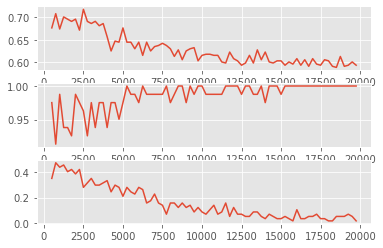

In [373]:
fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[1].plot(feat, recall_dems)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep)



As the features grew, the model began to classify more people as Democrats.  Maybe this means that republicans have a few defining words, but when the pool is broadened to more words, it gets diluted

In [ ]:
feat = np.arange(400, 2000, 100)
acc_small = []
recall_dems_small = []
recall_rep_small = []
for i in feat:
    clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = i, stop_words = sw)
    td, fr, fd, tr = confusion_matrix(y_test, clf.predict(X_test)).ravel()
    recall_d = td/(td + fr)
    recall_r = tr/(fd + tr)
    acc_small.append(cvs)
    recall_dems_small.append(recall_d)
    recall_rep_small.append(recall_r)

fig, ax = plt.subplots(3,1)

ax[0].plot(feat, acc_small)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[1].plot(feat, recall_dems_small)
#ax[0].scatter([feat[np.argsort(acc)[-5:]]], acc[np.argsort(acc)[-5:]])
#ax[0].title('Features vs Accuracy')
ax[2].plot(feat, recall_rep_small)

In [353]:
list(feat[np.argsort(acc)[-5:]])

[1500, 7000, 11750, 13000, 13750]

In [347]:
feat[np.argsort(acc)[-5:]]

array([ 1500,  7000, 11750, 13000, 13750])

In [ ]:
# Function used to calculate the decision boundary 
def decision_boundary_x2(x, b0, b1, b2, threshold):
    return (np.log((1 - threshold)/threshold) - b0 - x*b1 )/b2

def plot_decision_boundary(X, y, model, ax=None):
    '''plot 2-d array of points, with decision boundaries'''
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(X[:,0], X[:,1], color=np.where(y, 'g', 'b'), alpha=0.5, s=3)
    ax.plot(*X[y==0].mean(axis=0).reshape(-1,1), color='b', marker='+', mew=4, ms=20)
    ax.plot(*X[y==1].mean(axis=0).reshape(-1,1), color='g', marker='+', mew=4, ms=20)
    ax.axis('equal')

    xmin, xmax = X[:,0].min(), X[:,0].max()
    xrng = np.array([2*xmin-xmax, 2*xmax-xmin])

    ylim = ax.get_ylim()
    xlim = ax.get_xlim()

    beta0 = model.intercept_
    beta1, beta2 = model.coef_[0]
    print (beta0, beta1, beta2)
    
    get_prob = [df['prob'][i] for i in [400,600,800,1000,1200,1400,1600]]
    for threshold, ls in zip(get_prob, ['g','y','orange','r','purple','b','k']):  #[':', '-.', '--', '-', '--', '-.', ':']):
        ax.plot(xrng,
                decision_boundary_x2(xrng, beta0, beta1, beta2, threshold),
                color=ls,
              #  ls=ls,
                label="{:.2f}%".format(threshold*100))
    ax.legend(title='threshold')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

## ROC Curves

In [ ]:
clf, cvs, X_test, y_test = run_model(df.text, df.party, max_feat = 13000, stop_words = sw)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# keep probabilities for the positive outcome only
mnb_probs = clf.predict_proba
mnb_probs = mnb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
mnb_auc = roc_auc_score(y_test, mnb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
mnb_fpr, mnb_tpr, _ = roc_curve(testy, mnb_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(mnb_fpr, mnb_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
Credit goes to https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = max_feat)
X = tfidf.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(X, df.party, stratify = df.party)
# %
model = MultinomialNB()
visualizer = DiscriminationThreshold(model)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

In [ ]:
Credit goes to: https://www.scikit-yb.org/en/latest/api/classifier/threshold.html

In [ ]:
Make function, get cross-val score, recal, clf

## Looking at log probabilities to find the most "democratic" and "republican" speeches

In [271]:
def get_most_partisan(clf, X_test, y_test)
    prob_dem_list = []
    sorted_idx = np.argsort(clf.predict_proba(X_test)[:, 0])
                        
    for i,v in enumerate(list(clf.predict_proba(X_test))):
        prob = v[0]
        idx = list(y_test.index)[i]
        prob_repub_list.append([prob, idx])
    most_rep_idx = np.array(prob_repub_list)[sorted_idx][:5,1]
    most_dem_idx = np.array(prob_dem_list)[sorted_idx][-5:,1]
    return most_rep_idx, most_dem_idx

most_rep, most_dem = get_most_partisan(clf, X_test, y_test)
print('Most Republican')
print(df.loc[most_rep, ['name', 'title']])
print('Most Democrat')
print(df.loc[most_dem, ['name', 'title']]

LBJ appears in 4 of the top 5 spots.

Republicans: Reagan, GWBush (x2), Hoover, Bush Senior.

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
11,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress on ...,"March 6, 1991","<title=""Address Before a Joint Session of Cong...",False,False,False,False,False,2773,True
11,mondale,democrat,0,0,0,0,One of the key tests of leadership is whether...,False,True,False,False,False,4445,True
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229,True


In [279]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 100)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['end' 'energy' 'opportunity' 'done' 'billion' 'seek' 'place' 'nuclear'
 'land' 'plan' 'soviet' 'health' 'general' 'republican' 'human' 'common'
 'agreement' 'system' 'worker' 'history' 'woman' 'member' 'united nation'
 'better' 'party' 'economic' 'leader' 'see' 'care' 'back' 'never' 'act'
 'thank' 'viet-nam' 'still' 'responsibility' 'change' 'said' 'south'
 'citizen' 'long' 'interest' 'without' 'action' 'tax' 'home' 'economy'
 'community' 'together' 'military' 'much' 'give' 'well' 'take' 'program'
 'free' 'million' 'law' 'business' 'policy' 'problem' 'national' 'family'
 'security' 'future' 'tonight' 'power' 'believe' 'effort' 'good' 'bill'
 'child' 'hope' 'freedom' 'help' 'vietnam' 'job' 'need' 'life' 'force'
 'great' 'united state' 'congress' 'know' 'right' 'work' 'government'
 'america' 'think' 'united' 'new' 'country' 'state' 'peace' 'war'
 'president' 'world' 'nation' 'american' 'people']
one: ['east' 'interest' 'administration' 'toward' 'yet' 'ago' 'think' 'bill'
 'party' 

In [154]:
sw = stopwords.words('english')

new_sw = ['also', 'day','two', 'even', 'dont',"'ll", 'say', 'want', 'time', 'come', 'make', 'thing', 'le', "'m", 'go', 'thats', 'could', 'like', 'made', 'applause', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)


In [164]:
### Build confusion matrix:

In [130]:
print(clf.predict(X_test))
print(y_test)

['democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'democrat

## Looking at correct/incorrect data

In [280]:
df['accurate'] = 'na'
pred = []
idx = list(y_test.index)
for i, v in enumerate(list(y_test)):
    if v == clf.predict(X_test)[i]:
        df.loc[idx[i], 'accurate'] = True
    else:
        df.loc[idx[i], 'accurate'] = False

In [281]:
## Updates DF with whether the speech was accurately tagged

In [282]:
incorrect = df[df['accurate']==False]
incorrect.party.value_counts()

republican    32
democrat       2
Name: party, dtype: int64

In [283]:
incorrect.debate.value_counts()

False    34
Name: debate, dtype: int64

In [284]:
correct.debate.value_counts()

False    88
True     19
Name: debate, dtype: int64

In [285]:
df.debate.value_counts()

False    473
True      76
Name: debate, dtype: int64

In [137]:
print((23 + 19)/(23 + 19 + 38 + 23))
print(76/473)


0.4077669902912621
0.160676532769556


In [121]:
correct = df[df['accurate']==True]

In [301]:
counts_wrong = incorrect['name'].value_counts()

In [309]:
counts_right = correct['name'].value_counts()

In [318]:
right_wrong = pd.concat([counts_wrong, counts_right], axis = 1)
right_wrong = right_wrong.fillna(0)
right_wrong['correct %'] = (1 - right_wrong.iloc[:, 0]/(right_wrong.iloc[:, 0] + right_wrong.iloc[:, 1]))*100


In [319]:
right_wrong

,name,name,correct %
reagan,12.0,5.0,29.411765
ford,6.0,0.0,0.000000
bush,5.0,4.0,44.444444
nixon,3.0,0.0,0.000000
gwbush,3.0,7.0,70.000000
hoover,2.0,4.0,66.666667
eisenhower,1.0,0.0,0.000000
obama,1.0,15.0,93.750000
kennedy,1.0,8.0,88.888889
lbjohnson,0.0,20.0,100.000000


In [ ]:

def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## To do:
- ROC Curve/Threshold
- Take out debates
- Take out LBJ
- Look up uses of top words


## Wednesday Notes

Model has great recall for Democrats, bad recall for republicans.  Nixon has the most misclassifications (Checkers!).
Debates are poorly classified.

In [156]:
incorrect

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length,accurate
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False,3267,False
5,bush,republican,war,"<title=""Debate with Bill Clinton and Ross Pero...",Debate with Bill Clinton and Ross Perot,"October 11, 1992","Well, I think one thing that distinguishes is...",False,True,False,False,False,5597,False
6,bush,republican,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 28, 1992","\nMr. Speaker and Mr. President, distinguished...",False,False,False,True,False,5080,False
7,bush,republican,war,"<title=""Acceptance Speech at the Republican Na...",Acceptance Speech at the Republican National C...,"August 18, 1988",\nI have many friends to thank tonight. I than...,False,False,False,False,False,4127,False
8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902,False
10,bush,republican,war,"<title=""Address to the Nation on Panama"">\n<da...",Address to the Nation on Panama,"December 20, 1989","\nMy fellow citizens, last night I ordered U. ...",False,False,False,False,False,762,False
13,bush,republican,war,"<title=""Debate with Michael Dukakis"">\n<date=""...",Debate with Michael Dukakis,"September 25, 1988",I think we've seen a deterioration of values....,False,True,False,False,False,6135,False
23,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 6, 1976","Well, I think this Republican administration ...",False,True,False,False,False,5157,False
25,carter,democrat,nw,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 23, 1980","\nMr. President, Mr. Speaker, members of the 9...",False,False,False,True,False,3441,False
26,carter,democrat,nw,"<title=""Debate with President Gerald Ford"">\n<...",Debate with President Gerald Ford,"October 22, 1976","Well, I might say first of all, that I think ...",False,True,False,False,False,5281,False


In [163]:
print(df.loc[202,'text'])


<IN REPLY to press questions as to the business situation the President said:>
"The fundamental business of the country, that is the production and distribution of commodities, is on a sound and prosperous basis. The best evidence is that although production and consumption are at high levels, the average prices of commodities as a whole have not increased and there have been no appreciable increases in the stocks of manufactured goods. Moreover, there has been a tendency of wages to increase, the output per worker in many industries again shows an increase, all of which indicates a healthy condition.
"The construction and building material industries have been to some extent affected by the high interest rates induced by stock speculation and there has been some seasonal decrease in one or two other industries but these movements are of secondary character when considered in the whole situation.
"A temporary drop in grain prices sympathetically with stock exchange prices usually happ

In [114]:
df['name'].value_counts()
mis_class_by_pres = [['bush sr', 5/27], ['carter', 2/22], ['Eisenhower', 1/6], ['Ford', 2/17], 
                     ['GW', 7/45],['Hoover',4/29], ['Nixon', 6/27], ['Obama', 1/54], ['Reagan', 10/60]]
print(mis_class_by_pres)

[['bush sr', 0.18518518518518517], ['carter', 0.09090909090909091], ['Eisenhower', 0.16666666666666666], ['Ford', 0.11764705882352941], ['GW', 0.15555555555555556], ['Hoover', 0.13793103448275862], ['Nixon', 0.2222222222222222], ['Obama', 0.018518518518518517], ['Reagan', 0.16666666666666666]]


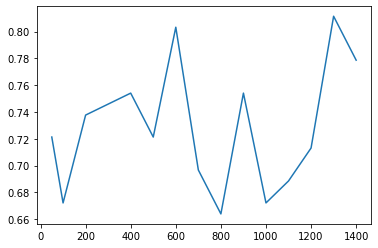

In [134]:
fig, ax = plt.subplots()
ax.plot(feat, scores)